# Convergence of dG(r), cG(r) and cG(r)-cG(r) time stepping schemes for exponential growth and harmonic oscillator

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sympy import *
from IPython.display import Math, display

t = symbols("t")
init_printing()

In [2]:
# Choosing some value for the timestep size to visualize the basis functions
_t = np.linspace(0., 1., 100)

In [3]:
# HELPER FUNCTIONS

# compute temporal basis functions from the roots
def compute_basis_functions(roots):
    basis = []
    for i in range(len(roots)):
        f = 1 + 0*Id(t)
        for j in range(len(roots)):
            if i != j:
                f = Mul(f,(t - roots[j]) / (roots[i] - roots[j])) 
        #basis.append(f)
        basis.append(expand(f))
    return basis

# transform roots from [-1, 1] to [0, 1]
def transform_roots(roots):
    new_roots = []
    for root in roots:
        new_roots.append((root + 1) / 2)
    return new_roots
        
# evaluate each basis functions at the time points
# optional: scale basis by basis_coeffs
def get_basis_values(basis, basis_coeffs=None):
    if basis_coeffs is None:
        basis_coeffs = np.ones((len(basis)))
    
    # evaluate basis function at time points
    vals = [np.zeros_like(_t) for _ in range(len(basis))]
    for n in range(len(basis)):
        for i in range(_t.shape[0]):
            vals[n][i] = basis_coeffs[n] * basis[n].evalf(subs={t: _t[i]})
    
    return vals

# get linear combination of basis vector values
def get_basis_lincomb(basis, basis_coeffs):
    vals = get_basis_values(basis, basis_coeffs)
    result = np.zeros_like(vals[0])
    for n in range(len(basis)):
        result += vals[n]
    return result

# plot each basis vector
def plot_basis(basis, title=None):
    basis_vals = get_basis_values(basis)
    
    for n in range(len(basis)):
        plt.plot(_t, basis_vals[n], label=rf"$\varphi_{{{n}}}$")

    plt.xlabel("t")
    plt.ylabel("f(t)")
    plt.legend()
    if title is not None:
        plt.title(title)
    plt.show()

##  Define Gauss-Lobatto temporal FE basis from $r = 0$ to $r = 6$

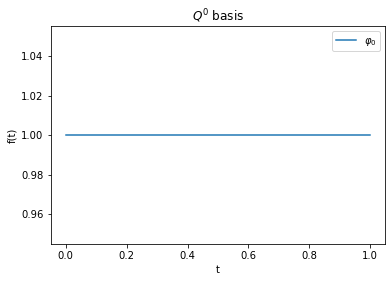

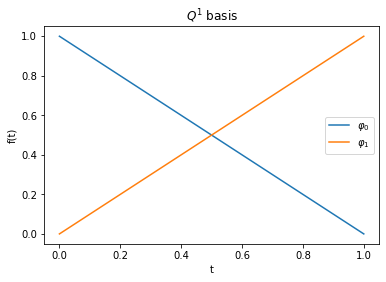

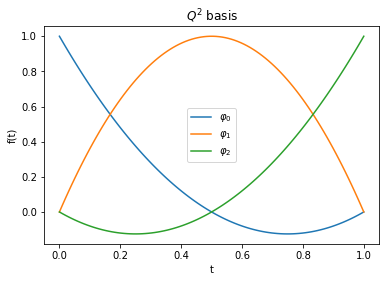

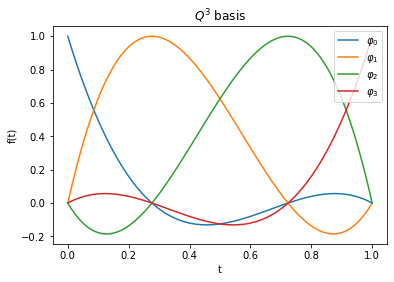

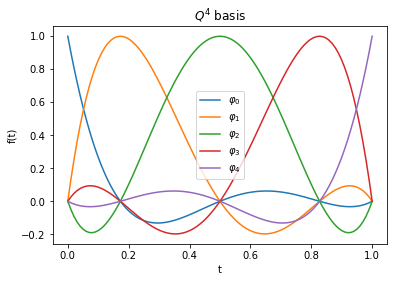

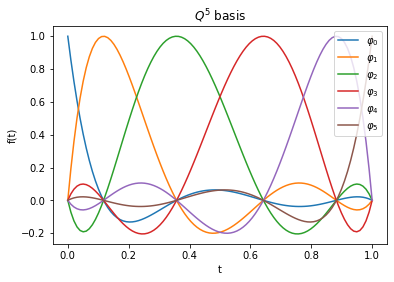

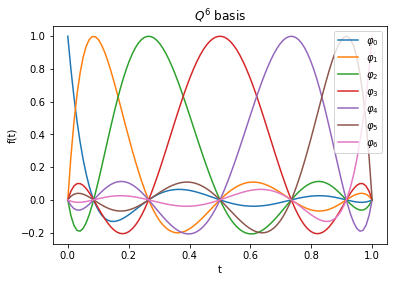

In [4]:
# dictionary of temporal bases depending on the polynomial degree
φ = {}
roots = {}

roots[0] = [1.]
φ[0] = [1 + 0*Id(t)]
roots[1] = [0., 1.]
φ[1] = [1-t, t]
roots[2] = transform_roots([-1, 0, 1])
φ[2] = compute_basis_functions(roots[2])
roots[3] = transform_roots([-1, -sqrt(Rational(1,5)), sqrt(Rational(1,5)), 1])
φ[3] = compute_basis_functions(roots[3])
roots[4] = transform_roots([-1, -sqrt(Rational(3,7)), 0, sqrt(Rational(3,7)), 1])
φ[4] = compute_basis_functions(roots[4])
roots[5] = transform_roots([
    -1, 
    -N(sqrt(Rational(1,3)+sqrt(7)*Rational(2,21))), 
    -N(sqrt(Rational(1,3)-sqrt(7)*Rational(2,21))), 
     N(sqrt(Rational(1,3)-sqrt(7)*Rational(2,21))),
     N(sqrt(Rational(1,3)+sqrt(7)*Rational(2,21))), 
     1
])
φ[5] = compute_basis_functions(roots[5])
roots[6] = transform_roots([
    -1, 
    -N(sqrt(Rational(5,11)+sqrt(Rational(5,3))*Rational(2,11))), 
    -N(sqrt(Rational(5,11)-sqrt(Rational(5,3))*Rational(2,11))),
     0,
     N(sqrt(Rational(5,11)-sqrt(Rational(5,3))*Rational(2,11))),
     N(sqrt(Rational(5,11)+sqrt(Rational(5,3))*Rational(2,11))), 
     1
])
φ[6] = compute_basis_functions(roots[6])

# plot bases from Q^0 to Q^6
for r in range(7):
    plot_basis(basis=φ[r], title=rf"$Q^{{{r}}}$ basis")

## Assemble temporal matrices for dG(r)
We assemble the temporal matrices
$$
\begin{align}
M_k &= \left\{ \int_{0}^1\varphi_k^{(j)}\cdot \varphi_k^{(i)}\ \mathrm{d}t \right\}_{i,j = 1}^{r+1}, \\
B_k &= \left\{ \int_{0}^1\partial_t\varphi_k^{(j)}\cdot \varphi_k^{(i)}\ \mathrm{d}t \right\}_{i,j = 1}^{r+1}.
\end{align}
$$
and then transfrom the integrals from $(0,1)$ to $I_m$ by multiplying $M_k$ by $k := t_m - t_{m-1}$.

In [5]:
from scipy.integrate import quad

def assemble_dGr_matrices(r):
    φ_r = φ[r]
    # initialize matrices
    matrix_M = [] # M_k
    matrix_B = [] # B_k
    for n in range(len(φ_r)):
        matrix_M.append([0.]*len(φ_r))
        matrix_B.append([0.]*len(φ_r))

    # assemble matrices (for dG(r) there are r+1 DoFs per element)
    for i in range(r+1):
        for j in range(r+1):
            matrix_M[i][j], _ = quad(lambda t_: (φ_r[j] * φ_r[i]).evalf(subs={t: t_}), 0, 1)
            matrix_B[i][j], _ = quad(lambda t_: (diff(φ_r[j], t) * φ_r[i]).evalf(subs={t: t_}), 0, 1)
    return matrix_M, matrix_B

matrix_M = {}
matrix_B = {}

for r in range(7):
    print("--------------")
    print(f"|   r = {r}   |")
    print("--------------")
    print("Assembing matrix... ", end="")
    matrix_M[r], matrix_B[r] = assemble_dGr_matrices(r=r) 
    print("Done.")
    
    # NOTE: Don't forget adding initial condition to matrix_B, i.e. matrix_B[0][0] += 1
    # Now matrix_B = B_k + D_k^1
    matrix_B[r][0][0] += 1
    
    #print(f"B[{r}] : {matrix_B[r]}")
    #print(f"M[{r}] : {matrix_M[r]}")

--------------
|   r = 0   |
--------------
Assembing matrix... Done.
--------------
|   r = 1   |
--------------
Assembing matrix... Done.
--------------
|   r = 2   |
--------------
Assembing matrix... Done.
--------------
|   r = 3   |
--------------
Assembing matrix... Done.
--------------
|   r = 4   |
--------------
Assembing matrix... Done.
--------------
|   r = 5   |
--------------
Assembing matrix... Done.
--------------
|   r = 6   |
--------------
Assembing matrix... Done.


## Solve exponent growth ODE with dG(r)

--------------
|   r = 0   |
--------------
Error: Singular matrix
k=1.0: Linear system could not be solved.
Error: list index out of range
--------------
|   r = 1   |
--------------
--------------
|   r = 2   |
--------------
--------------
|   r = 3   |
--------------
--------------
|   r = 4   |
--------------
--------------
|   r = 5   |
--------------
Final time error
Slope for dG(0): 1.150835327914126
Slope for dG(1): 3.064022590141982
Slope for dG(2): 5.060744018357351
Slope for dG(3): 7.090435232600964


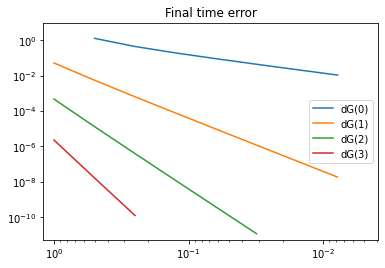

L2-norm error
Slope for dG(0): 1.1401838340191464
Slope for dG(1): 2.0213671828789366
Slope for dG(2): 3.008086884978012
Slope for dG(3): 4.001190843720068
Slope for dG(4): 4.994234409028245
Slope for dG(5): 5.977089688350071


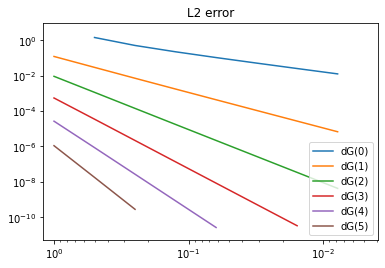

In [6]:
error = {"final": {}, "L2": {}}
T = 1. # end time

# solve dG(r) problems
for r in range(6):
    print("--------------")
    print(f"|   r = {r}   |")
    print("--------------")
    
    error["final"][r] = []
    error["L2"][r] = []
    
    # make solution plotting easier
    evaluation_matrix = np.zeros((_t.shape[0], r+1))
    for i in range(r+1):
        _vec = np.eye(1,r+1,i).flatten()
        evaluation_matrix[:, i] = get_basis_lincomb(φ[r], _vec)
    
    for k in [pow(0.5, i) for i in range(0,8)]:
        # assemble system matrix for dG(r)
        system_matrix = np.array(matrix_B[r]) - k * np.array(matrix_M[r])
    
        # assemble right hand side
        rhs = np.zeros((system_matrix.shape[0],))
        rhs[0] = 1.
        
        solution = []
        time_element = np.array([0., k])
        L2_error = 0.
        while time_element[0] + 1e-10 < T:
            try:
                solution.append(np.linalg.solve(system_matrix, rhs))
                
                time_linspace = time_element[0] + _t*k
                solution_linspace = evaluation_matrix.dot(solution[-1])
                true_solution_linspace = np.exp(time_linspace)
                error_linspace = np.abs(solution_linspace - true_solution_linspace)
                
                # compute L2 error with trapezoidal rule
                delta_t = time_linspace[1]-time_linspace[0]
                L2_error += delta_t * (np.sum(np.power(error_linspace[1:-1], 2.)) + 0.5 * (np.power(error_linspace[0], 2.) + np.power(error_linspace[-1], 2.)) ) 
                #plt.plot(time_linspace, solution_linspace, color="blue")
                #plt.plot(time_linspace, error_linspace, color="red")
                
                # set IC for next step
                rhs[0] = solution[-1][-1]
                # prepare next temporal element
                time_element += k
            except Exception as e:
                print("Error:", e)
                print(f"k={k}: Linear system could not be solved.")
                time_element += k
                
        try:
            error["final"][r].append([k, np.abs(np.exp(1) - solution[-1][-1])])
            error["L2"][r].append([k, np.sqrt(L2_error)])
            #plt.show() # plot solution or error trajectory
        except Exception as e:
            print("Error:", e)
            pass

print("Final time error")
plt.title("Final time error")
for r in error["final"].keys():
    if r > 3:
        continue
    k_vals = [e[0] for e in error["final"][r] if e[1] > 1e-12]
    err_vals = [e[1] for e in error["final"][r] if e[1] > 1e-12]
    if len(k_vals) > 1:
        x = k_vals
        y = err_vals
        plt.plot(x, y, label=f"dG({r})")
        plt.axis([1.2, pow(0.5, 8), 5e-12, 1e1])
        # NOTE: system matrix might become ill-conditioned for large r 
        #       and Gauss-Lobatto quad
        print(f"Slope for dG({r}): {(np.log(y[-1]) - np.log(y[0])) / (np.log(x[-1]) - np.log(x[0]))}")
plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.show()

print("L2-norm error")
plt.title("L2 error")
for r in error["L2"].keys():
    k_vals = [e[0] for e in error["L2"][r] if e[1] > 1e-11]
    err_vals = [e[1] for e in error["L2"][r] if e[1] > 1e-11]
    if len(k_vals) > 1:
        x = k_vals
        y = err_vals
        plt.plot(x, y, label=f"dG({r})")
        plt.axis([1.2, pow(0.5, 8), 5e-12, 1e1])
        # NOTE: system matrix might become ill-conditioned for large r 
        #       and Gauss-Lobatto quad
        print(f"Slope for dG({r}): {(np.log(y[-1]) - np.log(y[0])) / (np.log(x[-1]) - np.log(x[0]))}")
plt.legend(loc="lower right")
plt.xscale("log")
plt.yscale("log")
plt.show()

## Define Gauss-Legendre FE temporal basis from $r = 1$ to $r=6$

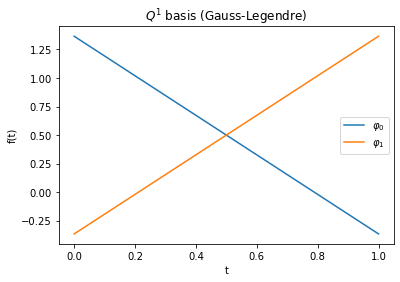

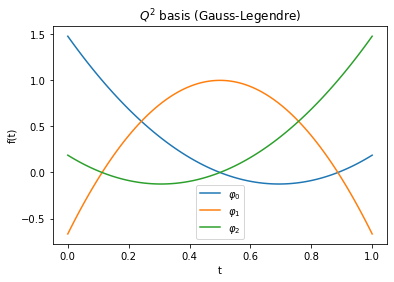

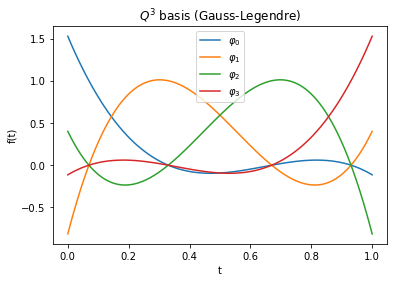

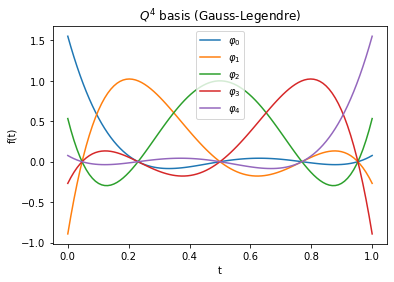

In [7]:
# dictionary of temporal bases for Gauss-Legendre quadrature depending on the polynomial degree
φ_Legendre = {}
roots_Legendre = {}

roots_Legendre[1] = transform_roots([-N(sqrt(Rational(1,3))), N(sqrt(Rational(1,3)))])
φ_Legendre[1] = compute_basis_functions(roots_Legendre[1])
roots_Legendre[2] = transform_roots([-N(sqrt(Rational(3,5))), 0, N(sqrt(Rational(3,5)))])
φ_Legendre[2] = compute_basis_functions(roots_Legendre[2])
roots_Legendre[3] = transform_roots([
    -N(sqrt(Rational(3,7) + Rational(2,7)*sqrt(Rational(6,5)))), 
    -N(sqrt(Rational(3,7) - Rational(2,7)*sqrt(Rational(6,5)))),
     N(sqrt(Rational(3,7) - Rational(2,7)*sqrt(Rational(6,5)))),
     N(sqrt(Rational(3,7) + Rational(2,7)*sqrt(Rational(6,5)))),
])
φ_Legendre[3] = compute_basis_functions(roots_Legendre[3])
roots_Legendre[4] = transform_roots([
    -N(Rational(1,3)*sqrt(5 + 2*sqrt(Rational(10,7)))), 
    -N(Rational(1,3)*sqrt(5 - 2*sqrt(Rational(10,7)))),
     0,
     N(Rational(1,3)*sqrt(5 - 2*sqrt(Rational(10,7)))),
     N(Rational(1,3)*sqrt(5 + 2*sqrt(Rational(10,7)))),
])
φ_Legendre[4] = compute_basis_functions(roots_Legendre[4])

# plot bases from Q^1 to Q^4
for r in range(1,5):
    plot_basis(basis=φ_Legendre[r], title=rf"$Q^{{{r}}}$ basis (Gauss-Legendre)")

## Assemble dG(r) Gauss-Legendre matrices

In [15]:
from scipy.integrate import quad

def assemble_dGr_Legendre_matrices(r):
    φ_r = φ_Legendre[r]
    # initialize matrices
    matrix_M = [] # M_k
    matrix_B = [] # B_k
    matrix_D_new = [] # D_k^+
    matrix_D_old = [] # D_k^-
    for n in range(len(φ_r)):
        matrix_M.append([0.]*len(φ_r))
        matrix_B.append([0.]*len(φ_r))
        matrix_D_new.append([0.]*len(φ_r))
        matrix_D_old.append([0.]*len(φ_r))

    # assemble matrices (for dG(r) there are r+1 DoFs per element)
    for i in range(r+1):
        for j in range(r+1):
            matrix_M[i][j], _ = quad(lambda t_: (φ_r[j] * φ_r[i]).evalf(subs={t: t_}), 0, 1)
            matrix_B[i][j], _ = quad(lambda t_: (diff(φ_r[j], t) * φ_r[i]).evalf(subs={t: t_}), 0, 1)
            
            matrix_D_new[i][j] = N(φ_r[j].replace(t, 0) * φ_r[i].replace(t, 0))
            matrix_D_old[i][j] = N(φ_r[j].replace(t, 1) * φ_r[i].replace(t, 0))
    return matrix_M, matrix_B, matrix_D_new, matrix_D_old

matrix_M = {}
matrix_B = {}
matrix_D_new = {}
matrix_D_old = {}

for r in range(1,5):
    print("--------------")
    print(f"|   r = {r}   |")
    print("--------------")
    print("Assembing matrix... ", end="")
    matrix_M[r], matrix_B[r], matrix_D_new[r], matrix_D_old[r] = assemble_dGr_Legendre_matrices(r=r) 
    print("Done.")

--------------
|   r = 1   |
--------------
Assembing matrix... Done.
--------------
|   r = 2   |
--------------
Assembing matrix... Done.
--------------
|   r = 3   |
--------------
Assembing matrix... Done.
--------------
|   r = 4   |
--------------
Assembing matrix... Done.


## Solve the exponential growth ODE with dG(r) Gauss-Legendre

--------------
|   r = 1   |
--------------
--------------
|   r = 2   |
--------------
--------------
|   r = 3   |
--------------
--------------
|   r = 4   |
--------------
Final time error
Slope for dG(1): 3.0640224430102934
Slope for dG(2): 5.062791693780004
Slope for dG(3): 7.090256134422077


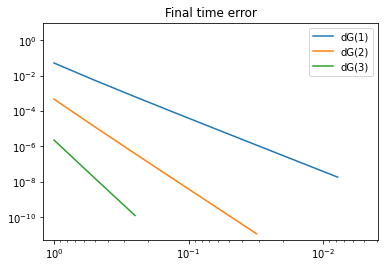

L2-norm error
Slope for dG(1): 2.0213671828786652
Slope for dG(2): 3.0080868826116545
Slope for dG(3): 4.00118740983878
Slope for dG(4): 4.994195336587088


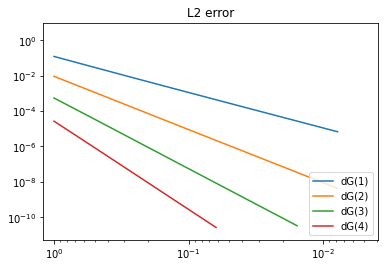

In [18]:
error = {"final": {}, "L2": {}}
T = 1. # end time

# solve dG(r) Gauss-Legendre problems
for r in range(1,5):
    print("--------------")
    print(f"|   r = {r}   |")
    print("--------------")
    
    error["final"][r] = []
    error["L2"][r] = []
    
    # make solution plotting easier
    evaluation_matrix = np.zeros((_t.shape[0], r+1))
    for i in range(r+1):
        _vec = np.eye(1,r+1,i).flatten()
        evaluation_matrix[:, i] = get_basis_lincomb(φ_Legendre[r], _vec)
    
    for k in [pow(0.5, i) for i in range(0,8)]:
        # assemble system matrix for dG(r)
        system_matrix = (np.array(matrix_B[r]) + np.array(matrix_D_new[r]) - k * np.array(matrix_M[r])).astype('float64')
        matrix_D_old[r] = np.array(matrix_D_old[r]).astype('float64')
        
        # assemble right hand side
        rhs = np.dot(
            matrix_D_old[r], 
            np.ones((system_matrix.shape[0],))
        )
        
        solution = []
        time_element = np.array([0., k])
        L2_error = 0.
        while time_element[0] + 1e-10 < T:
            try:
                solution.append(np.linalg.solve(system_matrix, rhs))
                
                time_linspace = time_element[0] + _t*k
                solution_linspace = evaluation_matrix.dot(solution[-1])
                true_solution_linspace = np.exp(time_linspace)
                error_linspace = np.abs(solution_linspace - true_solution_linspace)
                
                # compute L2 error with trapezoidal rule
                delta_t = time_linspace[1]-time_linspace[0]
                L2_error += delta_t * (np.sum(np.power(error_linspace[1:-1], 2.)) + 0.5 * (np.power(error_linspace[0], 2.) + np.power(error_linspace[-1], 2.)) ) 
                #plt.plot(time_linspace, solution_linspace, color="blue")
                #plt.plot(time_linspace, error_linspace, color="red")
                
                # set IC for next step
                rhs = np.dot(
                    matrix_D_old[r], 
                    solution[-1]
                )
                
                # prepare next temporal element
                time_element += k
            except Exception as e:
                print("Error:", e)
                print(f"k={k}: Linear system could not be solved.")
                time_element += k
                
        try:
            terminal_solution = evaluation_matrix.dot(solution[-1])[-1]
            error["final"][r].append([k, np.abs(np.exp(1) - terminal_solution)])
            error["L2"][r].append([k, np.sqrt(L2_error)])
            #plt.show() # plot solution or error trajectory
        except Exception as e:
            print("Error:", e)
            pass

print("Final time error")
plt.title("Final time error")
for r in error["final"].keys():
    if r > 3:
        continue
    k_vals = [e[0] for e in error["final"][r] if e[1] > 1e-12]
    err_vals = [e[1] for e in error["final"][r] if e[1] > 1e-12]
    if len(k_vals) > 1:
        x = k_vals
        y = err_vals
        plt.plot(x, y, label=f"dG({r})")
        plt.axis([1.2, pow(0.5, 8), 5e-12, 1e1])
        # NOTE: system matrix might become ill-conditioned for large r 
        #       and Gauss-Lobatto quad
        print(f"Slope for dG({r}): {(np.log(y[-1]) - np.log(y[0])) / (np.log(x[-1]) - np.log(x[0]))}")
plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.show()

print("L2-norm error")
plt.title("L2 error")
for r in error["L2"].keys():
    k_vals = [e[0] for e in error["L2"][r] if e[1] > 1e-11]
    err_vals = [e[1] for e in error["L2"][r] if e[1] > 1e-11]
    if len(k_vals) > 1:
        x = k_vals
        y = err_vals
        plt.plot(x, y, label=f"dG({r})")
        plt.axis([1.2, pow(0.5, 8), 5e-12, 1e1])
        # NOTE: system matrix might become ill-conditioned for large r 
        #       and Gauss-Lobatto quad
        print(f"Slope for dG({r}): {(np.log(y[-1]) - np.log(y[0])) / (np.log(x[-1]) - np.log(x[0]))}")
plt.legend(loc="lower right")
plt.xscale("log")
plt.yscale("log")
plt.show()

## Assemble temporal matrices for cG(r)
We assemble the temporal matrices
$$
\begin{align}
    M_k &= \left\{ \int_{I_m}\varphi_k^{cG, (j)}\cdot \varphi_k^{dG, (i)}\ \mathrm{d}t \right\}_{i,j = 1}^{r,r+1}, \\
    B_k &= \left\{ \int_{I_m}\partial_t\varphi_k^{cG, (j)}\cdot \varphi_k^{dG, (i)}\ \mathrm{d}t \right\}_{i,j = 1}^{r,r+1}.
\end{align}
$$
Note that the dG basis functions are one degree lower, i.e. for $cG(r)$ we use $cG(r)$ trial and $dG(r)$ test functions.

In [21]:
def assemble_cGr_matrices(r):
    φ_r = φ[r] # trial functions
    ψ_r = φ[r-1] # test functions
    # initialize matrices
    matrix_M = [] # M_k
    matrix_B = [] # B_k
    for n in range(len(ψ_r)):
        matrix_M.append([0.]*len(φ_r))
        matrix_B.append([0.]*len(φ_r))

    # assemble matrices (for Q^r there are r+1 DoFs per element and for Q^{r-1} there are r DoFs)
    for i in range(r):
        for j in range(r+1):
            matrix_M[i][j], _ = quad(lambda t_: (φ_r[j] * ψ_r[i]).evalf(subs={t: t_}), 0, 1)
            matrix_B[i][j], _ = quad(lambda t_: (diff(φ_r[j], t) * ψ_r[i]).evalf(subs={t: t_}), 0, 1)
    return matrix_M, matrix_B

matrix_M = {}
matrix_B = {}

for r in range(1,7):
    print("--------------")
    print(f"|   r = {r}   |")
    print("--------------")
    print("Assembing matrix... ", end="")
    matrix_M[r], matrix_B[r] = assemble_cGr_matrices(r=r) 
    print("Done.")
    
    #print(f"B[{r}] : {matrix_B[r]}")
    #print(f"M[{r}] : {matrix_M[r]}")

--------------
|   r = 1   |
--------------
Assembing matrix... Done.
--------------
|   r = 2   |
--------------
Assembing matrix... Done.
--------------
|   r = 3   |
--------------
Assembing matrix... Done.
--------------
|   r = 4   |
--------------
Assembing matrix... Done.
--------------
|   r = 5   |
--------------
Assembing matrix... Done.
--------------
|   r = 6   |
--------------
Assembing matrix... Done.


--------------
|   r = 1   |
--------------
--------------
|   r = 2   |
--------------
--------------
|   r = 3   |
--------------
--------------
|   r = 4   |
--------------
--------------
|   r = 5   |
--------------
Final time error
Slope for cG(1): 2.0449393017219077
Slope for cG(2): 4.011790146149569
Slope for cG(3): 6.014297031010687


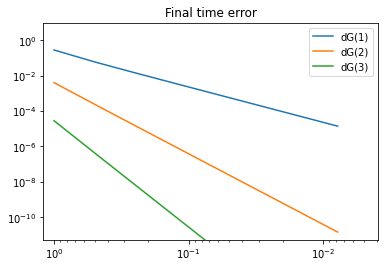

L2-norm error
Slope for cG(1): 2.032129581954333
Slope for cG(2): 2.9874360759915772
Slope for cG(3): 3.9841936425264666
Slope for cG(4): 4.975348679976721
Slope for cG(5): 5.952495501586479


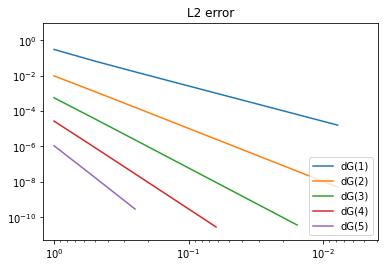

In [24]:
error = {"final": {}, "L2": {}}
T = 1. # end time

# solve cG(r) problems
for r in range(1,6):
    print("--------------")
    print(f"|   r = {r}   |")
    print("--------------")
    
    error["final"][r] = []
    error["L2"][r] = []
    
    # make solution plotting easier
    evaluation_matrix = np.zeros((_t.shape[0], r+1))
    for i in range(r+1):
        _vec = np.eye(1,r+1,i).flatten()
        evaluation_matrix[:, i] = get_basis_lincomb(φ[r], _vec)
    
    for k in [pow(0.5, i) for i in range(0,8)]:
        # assemble system matrix for cG(r)
        system_matrix = (np.array(matrix_B[r]) - k * np.array(matrix_M[r]))[:, 1:]
        rhs_vector = -(np.array(matrix_B[r]) - k * np.array(matrix_M[r]))[:, 0]
    
        # assemble right hand side
        initial_condition = 1.
        rhs = initial_condition * rhs_vector[:]
        
        solution = []
        time_element = np.array([0., k])
        L2_error = 0.
        while time_element[0] + 1e-10 < T:
            try:
                solution.append(np.hstack(
                    (
                        np.array([initial_condition]),
                        np.linalg.solve(system_matrix, rhs)
                    )
                ))
                
                time_linspace = time_element[0] + _t*k
                solution_linspace = evaluation_matrix.dot(solution[-1])
                true_solution_linspace = np.exp(time_linspace)
                error_linspace = np.abs(solution_linspace - true_solution_linspace)
                
                # compute L2 error with trapezoidal rule
                delta_t = time_linspace[1]-time_linspace[0]
                L2_error += delta_t * (np.sum(np.power(error_linspace[1:-1], 2.)) + 0.5 * (np.power(error_linspace[0], 2.) + np.power(error_linspace[-1], 2.)) ) 
                #plt.plot(time_linspace, solution_linspace, color="blue")
                #plt.plot(time_linspace, error_linspace, color="red")
                
                # set IC for next step
                initial_condition = solution[-1][-1]
                rhs = initial_condition * rhs_vector[:]
                # prepare next temporal element
                time_element += k
            except Exception as e:
                print("Error:", e)
                print(f"k={k}: Linear system could not be solved.")
                time_element += k
                
        try:
            error["final"][r].append([k, np.abs(np.exp(1) - solution[-1][-1])])
            error["L2"][r].append([k, np.sqrt(L2_error)])
            #plt.show() # plot solution or error trajectory
        except Exception as e:
            print("Error:", e)
            pass

print("Final time error")
plt.title("Final time error")
for r in error["final"].keys():
    if r > 3:
        continue
    k_vals = [e[0] for e in error["final"][r] if e[1] > 1e-12]
    err_vals = [e[1] for e in error["final"][r] if e[1] > 1e-12]
    if len(k_vals) > 1:
        x = k_vals
        y = err_vals
        plt.plot(x, y, label=f"cG({r})")
        plt.axis([1.2, pow(0.5, 8), 5e-12, 1e1])
        print(f"Slope for cG({r}): {(np.log(y[-1]) - np.log(y[0])) / (np.log(x[-1]) - np.log(x[0]))}")
plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.show()

print("L2-norm error")
plt.title("L2 error")
for r in error["L2"].keys():
    k_vals = [e[0] for e in error["L2"][r] if e[1] > 1e-11]
    err_vals = [e[1] for e in error["L2"][r] if e[1] > 1e-11]
    if len(k_vals) > 1:
        x = k_vals
        y = err_vals
        plt.plot(x, y, label=f"cG({r})")
        plt.axis([1.2, pow(0.5, 8), 5e-12, 1e1])
        # NOTE: system matrix might become ill-conditioned for large r 
        #       and Gauss-Lobatto quad
        print(f"Slope for cG({r}): {(np.log(y[-1]) - np.log(y[0])) / (np.log(x[-1]) - np.log(x[0]))}")
plt.legend(loc="lower right")
plt.xscale("log")
plt.yscale("log")
plt.show()

## Assemble temporal matrices for cG(r)-cG(r)
We assemble the temporal matrices
$$
\begin{align}
    M_k &= \left\{ \int_{I_m}\varphi_k^{(j)}\cdot \varphi_k^{(i)}\ \mathrm{d}t \right\}_{i,j = 1}^{r+1}, \\
    B_k &= \left\{ \int_{I_m}\partial_t\varphi_k^{(j)}\cdot \varphi_k^{(i)}\ \mathrm{d}t \right\}_{i,j = 1}^{r+1}.
\end{align}
$$
Then we clearly the first row of the matrices by enforcing the initial condition.

In [25]:
def assemble_cGr_cGr_matrices(r):
    φ_r = φ[r]
    # initialize matrices
    matrix_M = [] # M_k
    matrix_B = [] # B_k
    for n in range(len(φ_r)):
        matrix_M.append([0.]*len(φ_r))
        matrix_B.append([0.]*len(φ_r))

    # assemble matrices (for Q^r there are r+1 DoFs per element)
    for i in range(r+1):
        for j in range(r+1):
            matrix_M[i][j], _ = quad(lambda t_: (φ_r[j] * φ_r[i]).evalf(subs={t: t_}), 0, 1)
            matrix_B[i][j], _ = quad(lambda t_: (diff(φ_r[j], t) * φ_r[i]).evalf(subs={t: t_}), 0, 1)
    return matrix_M, matrix_B

def enforce_initial_condition(matrix, first_value=0.):
    # initialize matrix
    new_matrix= []
    for n in range(len(matrix)):
        new_matrix.append([0.]*len(matrix[n]))
    new_matrix[0][0] = first_value    
        
    # copy everything starting at the SECOND row
    for i in range(1,len(matrix)):
        for j in range(len(matrix[i])):
            new_matrix[i][j] = matrix[i][j]
    return new_matrix

matrix_M = {}
matrix_B = {}

for r in range(1,7):
    print("--------------")
    print(f"|   r = {r}   |")
    print("--------------")
    print("Assembing matrix... ", end="")
    matrix_M[r], matrix_B[r] = assemble_cGr_cGr_matrices(r=r)
    matrix_M[r] = enforce_initial_condition(matrix_M[r], first_value=0)
    matrix_B[r] = enforce_initial_condition(matrix_B[r], first_value=1)
    print("Done.")

--------------
|   r = 1   |
--------------
Assembing matrix... Done.
--------------
|   r = 2   |
--------------
Assembing matrix... Done.
--------------
|   r = 3   |
--------------
Assembing matrix... Done.
--------------
|   r = 4   |
--------------
Assembing matrix... Done.
--------------
|   r = 5   |
--------------
Assembing matrix... Done.
--------------
|   r = 6   |
--------------
Assembing matrix... Done.


## Solve the exponential growth ODE with cG(r)-cG(r)

--------------
|   r = 1   |
--------------
--------------
|   r = 2   |
--------------
--------------
|   r = 3   |
--------------
--------------
|   r = 4   |
--------------
--------------
|   r = 5   |
--------------
Final time error
Slope for cG(1)-cG(1): 1.0991998964045213
Slope for cG(2)-cG(2): 2.0715441668786467
Slope for cG(3)-cG(3): 3.0688535589445203


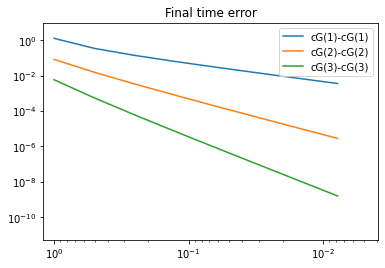

L2-norm error
Slope for cG(1)-cG(1): 1.1573322850528849
Slope for cG(2)-cG(2): 2.12829250659218
Slope for cG(3)-cG(3): 3.1252493805033548
Slope for cG(4)-cG(4): 4.173443386434805
Slope for cG(5)-cG(5): 5.266769055079337


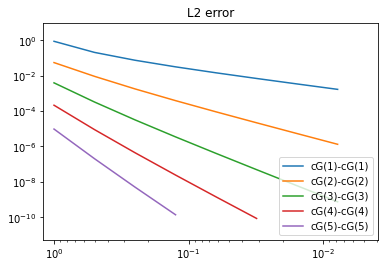

In [28]:
error = {"final": {}, "L2": {}}
T = 1. # end time

# solve cG(r)-cG(r) problems
for r in range(1,6):
    print("--------------")
    print(f"|   r = {r}   |")
    print("--------------")
    
    error["final"][r] = []
    error["L2"][r] = []
    
    # make solution plotting easier
    evaluation_matrix = np.zeros((_t.shape[0], r+1))
    for i in range(r+1):
        _vec = np.eye(1,r+1,i).flatten()
        evaluation_matrix[:, i] = get_basis_lincomb(φ[r], _vec)
    
    for k in [pow(0.5, i) for i in range(0,8)]:
        # assemble system matrix for cG(r)-cG(r)
        system_matrix = (np.array(matrix_B[r]) - k * np.array(matrix_M[r])).astype('float64')
        
        # assemble right hand side
        rhs = np.zeros((system_matrix.shape[0],))
        rhs[0] = 1.
        
        solution = []
        time_element = np.array([0., k])
        L2_error = 0.
        while time_element[0] + 1e-10 < T:
            try:
                solution.append(np.linalg.solve(system_matrix, rhs))
                
                time_linspace = time_element[0] + _t*k
                solution_linspace = evaluation_matrix.dot(solution[-1])
                true_solution_linspace = np.exp(time_linspace)
                error_linspace = np.abs(solution_linspace - true_solution_linspace)
                
                # compute L2 error with trapezoidal rule
                delta_t = time_linspace[1]-time_linspace[0]
                L2_error += delta_t * (np.sum(np.power(error_linspace[1:-1], 2.)) + 0.5 * (np.power(error_linspace[0], 2.) + np.power(error_linspace[-1], 2.)) ) 
                #plt.plot(time_linspace, solution_linspace, color="blue")
                #plt.plot(time_linspace, error_linspace, color="red")
                
                # set IC for next step
                rhs[0] = solution[-1][-1]
                
                # prepare next temporal element
                time_element += k
            except Exception as e:
                print("Error:", e)
                print(f"k={k}: Linear system could not be solved.")
                time_element += k
                
        try:
            terminal_solution = solution[-1][-1]
            error["final"][r].append([k, np.abs(np.exp(1) - terminal_solution)])
            error["L2"][r].append([k, np.sqrt(L2_error)])
            #plt.show() # plot solution or error trajectory
        except Exception as e:
            print("Error:", e)
            pass

print("Final time error")
plt.title("Final time error")
for r in error["final"].keys():
    if r > 3:
        continue
    k_vals = [e[0] for e in error["final"][r] if e[1] > 1e-12]
    err_vals = [e[1] for e in error["final"][r] if e[1] > 1e-12]
    if len(k_vals) > 1:
        x = k_vals
        y = err_vals
        plt.plot(x, y, label=f"cG({r})-cG({r})")
        plt.axis([1.2, pow(0.5, 8), 5e-12, 1e1])
        print(f"Slope for cG({r})-cG({r}): {(np.log(y[-1]) - np.log(y[1])) / (np.log(x[-1]) - np.log(x[1]))}")
plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.show()

print("L2-norm error")
plt.title("L2 error")
for r in error["L2"].keys():
    k_vals = [e[0] for e in error["L2"][r] if e[1] > 1e-11]
    err_vals = [e[1] for e in error["L2"][r] if e[1] > 1e-11]
    if len(k_vals) > 1:
        x = k_vals
        y = err_vals
        plt.plot(x, y, label=f"cG({r})-cG({r})")
        plt.axis([1.2, pow(0.5, 8), 5e-12, 1e1])
        print(f"Slope for cG({r})-cG({r}): {(np.log(y[-1]) - np.log(y[1])) / (np.log(x[-1]) - np.log(x[1]))}")
plt.legend(loc="lower right")
plt.xscale("log")
plt.yscale("log")
plt.show()